In [19]:
import pickle
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from modules_gd.model import VAE
from modules_gd.data import MSA_Dataset

## Inspect the pre-processed MSA

In [20]:
MSA_id = "COG438-l150-s1"
data_path = f"data/simulations/processed/{MSA_id}"

In [21]:
!echo Total number of sequences:
! wc -l {data_path}/seq_msa_char.txt 
#!echo Check that outgroup sequence present:
#! grep {outgroup_acc} {data_path}/seq_msa_char.txt
!echo Print first 25 sequences:
! head -n 25 {data_path}/seq_msa_char.txt 

Total number of sequences:
    4996 data/simulations/processed/COG438-l150-s1/seq_msa_char.txt
Print first 25 sequences:
N3973	RRRWLPAVMSSSLATVLDIMAEEVFAQCVLLRNYVIKLVIRFDPMWMTKIPEALGMMLGILVTFIGYQDTAKRLLNQTETNSSERINTKLDAGCVMAGLLGTYKWTDRVVHGNVPEYSEMNNIKVVKFATPMCPRYFQYVQIKLIIAIKT
N2849	RRRWLPAVMSSSLATVLDIMAEEVFAQCVLLRNYVIKLVIRFDPMWMTKIPEALGMMLGILVTFIGYQDTAKRLLNQTETNASERINTKLDAGCVMEGFLGTYKWTDRVVHGNVPEYSEMNNIKVVKFATPMCPRYFQYVQIKLIIAIKT
N1217	RRHIYAELLTDIIFSSVSDDVVNEFVSSAQVPKQIQLLRIRFAAMPLSNKPEALGSLLGPVVKVIFYQKAKAYLLDEDQYGCPEEAEEDPDLVYIYPAILKTTGFDELIMRRYISGYGETGMIRPFARALQKCVVHLQAVQIRLLNAVDY
N4531	RRHWVVNALYQIMIGAIHVATAEFVDQNVALRSVIQLTAVKYEELKLKSYTEKLTAVAGVLIQVFSFQNCRARPLEKKTIGCKKKISMDPDVAWVVSDLVLNSLLRGQILHVHTAPYGATNAIKVFENSIKMKEEYLQKVPITLVIAVGR
N4759	RRHWLDRYLRLKLLGSLDTTVSELTEDQRTVNQRVEVEKSKFEAMNFTSKPEEVAMQLGLVIRIVTYPYVPNKLFPENAVHCQQHKNQKVDLAHDFPGVVTSSRFNEHAWRGKIVSYRVGYLVKVAELAVRVVPRYFAQLPIKIIFSDEQ
N235	RRHWLVSKGHNMLFQPINIAVRHFIGQCAKIAPPIRLTAPRFGATNCETTTDSVAALLGVLIRAVTYSNAKSAIIEGGLIHASQLITVN

## Load data and instantiate dataset

In [22]:
## read in binary representation of MSA
with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([4996, 150, 21])

In [23]:
## each sequence has a label
with open(f"{data_path}/seq_names.pkl", 'rb') as file_handle:
    seq_names = pickle.load(file_handle)
seq_names[:10]

['N3973',
 'N2849',
 'N1217',
 'N4531',
 'N4759',
 'N235',
 'N2936',
 'N1839',
 'N2596',
 'N2287']

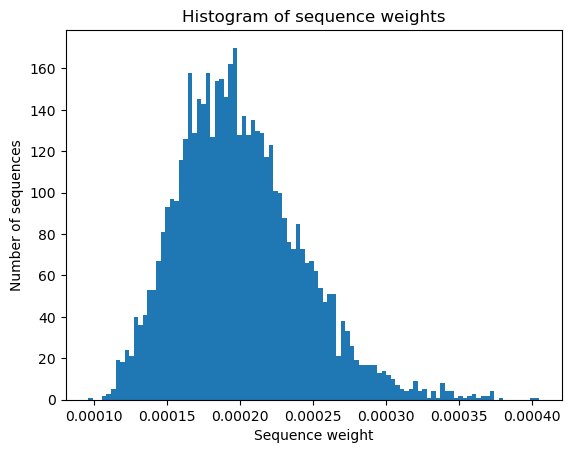

In [24]:
## sequences in msa are weighted
with open(f"{data_path}/seq_weight.pkl", 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)
# make a histogram of seq_weight
import matplotlib.pyplot as plt
plt.hist(seq_weight, bins=100)
plt.xlabel('Sequence weight')
plt.ylabel('Number of sequences')
plt.title('Histogram of sequence weights')
plt.show()
# assert that the sum of the weights is approximately 1
assert np.abs(seq_weight.sum()-1) < 1e-6
# If you want to have equal weight for each sequence, run this code
# seq_weight = np.ones_like(seq_weight)/n_seq

In [25]:
data = MSA_Dataset(msa_binary, seq_weight, seq_names)
# Show a random example
data[1]

(tensor([[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 0.00020919876,
 'N2849')

We see that an item of the dataset contains the one-hot representation of the sequence, the weight assigned to the sequence (explained later), and the name of the sequence

## Instantiate model

In [26]:
# For architecture hyper-parameters, we rely on the defaults in the class definition
model = VAE(nl = nl, nc = nc, dim_latent_vars = 2)

Let's check that our model processes data the way we want it to

In [27]:
#Encoding
one_hot_ary = data[100][0]
batch_one_hot_ary = torch.unsqueeze(one_hot_ary, 0)
latent_parameters = model.encoder(batch_one_hot_ary)
print(f"Mean and variance of latent vector:")
print(latent_parameters)
#Decoding
mn_z = latent_parameters[0]
recon_log_probs = model.decoder(mn_z)
print(f"Decoded output has shape {recon_log_probs.shape} and is given by:")
print(recon_log_probs)
probs = torch.exp(recon_log_probs.squeeze())
print("The probability for each amino acid in each position is:")
print(probs)
print("Rows should sum to 1: ")
print(torch.sum(probs, dim = 1))

Mean and variance of latent vector:
(tensor([[ 0.0186, -0.0425]], grad_fn=<AddmmBackward0>), tensor([[0.9849, 0.9297]], grad_fn=<ExpBackward0>))
Decoded output has shape torch.Size([1, 150, 21]) and is given by:
tensor([[[-3.1137, -3.0842, -2.9934,  ..., -2.9963, -2.9258, -2.9626],
         [-3.0900, -3.1836, -2.9794,  ..., -3.1549, -2.8118, -3.0165],
         [-3.0077, -3.0863, -3.0121,  ..., -3.1201, -2.9719, -2.9950],
         ...,
         [-3.0048, -3.0798, -3.0020,  ..., -3.0386, -3.0512, -3.0659],
         [-2.9694, -2.9139, -3.1504,  ..., -3.0175, -3.0713, -3.0880],
         [-2.9892, -3.0255, -3.0549,  ..., -2.9194, -3.0265, -3.1711]]],
       grad_fn=<LogSoftmaxBackward0>)
The probability for each amino acid in each position is:
tensor([[0.0444, 0.0458, 0.0501,  ..., 0.0500, 0.0536, 0.0517],
        [0.0455, 0.0414, 0.0508,  ..., 0.0426, 0.0601, 0.0490],
        [0.0494, 0.0457, 0.0492,  ..., 0.0442, 0.0512, 0.0500],
        ...,
        [0.0496, 0.0460, 0.0497,  ..., 0.0479,

## Train model

In [28]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyperparameters
num_epochs = 100
wd = 0.01
dim_lat = 2
bs = 64
verbose = False

cpu


In [29]:
# Define how to do an epoch of training
def train(model, device, train_loader, optimizer, epoch, verbose):

  model.train()
  running_elbo = []

  for batch_idx, (msa, weight, _) in enumerate(train_loader):
    msa, weight = msa.to(device), weight.to(device)
    optimizer.zero_grad()
    loss = (-1)*model.compute_weighted_elbo(msa, weight)
    loss.backward()
    optimizer.step()
    elbo_scalar = -loss.item()
    if verbose:
      print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, elbo_scalar), \
            flush = True)
    running_elbo.append(elbo_scalar)

  return running_elbo

# Define how to evaluate the model on the validation data
def eval(model, device, valid_loader, recon = False):

  model.eval()
  elbos = []
  if recon:
    recon_accs = []
  with torch.no_grad():
    for (msa, _, _) in valid_loader:
      msa = msa.to(device)
      # compute elbo loss
      elbo = model.compute_elbo_with_multiple_samples(msa, 100) # how many samples to use for IWAE estimate of ELBO
      elbo_scalar = torch.mean(elbo).item()
      elbos.append(elbo_scalar)


      if recon:
        # compute proportion of amino acids correctly reconstructed
        real = torch.argmax(msa, -1)
        mu, _ = model.encoder(msa)
        p = torch.exp(model.decoder(mu))
        preds = torch.argmax(p, -1)
        recon_acc = torch.sum(real == preds)/real.nelement()
        recon_acc_scalar = recon_acc.data.item()
        recon_accs.append(recon_acc_scalar)

  return elbos, recon_accs



In [30]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(len(data)), test_size = 0.1, random_state = 42)
train_loader = DataLoader(data, batch_size = bs, sampler = torch.utils.data.SubsetRandomSampler(train_idx))
test_loader = DataLoader(data, batch_size = bs, sampler = torch.utils.data.SubsetRandomSampler(test_idx))

In [31]:
model = VAE(nl=nl, nc=nc, dim_latent_vars=dim_lat).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = wd) 

train_elbos = []
test_elbos = []
test_recon_accs = []
for epoch in range(num_epochs):
  batch_elbos, batch_recon_accs = eval(model, device, test_loader, recon = True)
  epoch_test_elbo, epoch_test_recon_acc = np.mean(batch_elbos), np.mean(batch_recon_accs)
  test_elbos.append(epoch_test_elbo)
  test_recon_accs.append(epoch_test_recon_acc)
  print(f"Test elbo for epoch {epoch}: {epoch_test_elbo}")
  print(f"Test reconstruction accuracy for fold epoch {epoch}: {epoch_test_recon_acc}")
  batch_elbos = train(model, device, train_loader, optimizer, epoch, verbose)
  epoch_train_elbo = np.mean(batch_elbos)
  train_elbos.append(epoch_train_elbo)
  print(f"Training elbo for epoch {epoch}: {epoch_train_elbo}")
  

Test elbo for epoch 0: -457.49110960202404
Test reconstruction accuracy for fold epoch 0: 0.05774038517847657
Training elbo for epoch 0: -352.6150306379291
Test elbo for epoch 1: -334.08454032441307
Test reconstruction accuracy for fold epoch 1: 0.35856570303440094
Training elbo for epoch 1: -336.67894476232397
Test elbo for epoch 2: -333.7933450887781
Test reconstruction accuracy for fold epoch 2: 0.359350960701704
Training elbo for epoch 2: -336.47203644228654
Test elbo for epoch 3: -333.81909502844894
Test reconstruction accuracy for fold epoch 3: 0.3587319701910019
Training elbo for epoch 3: -336.2767076089349
Test elbo for epoch 4: -333.34192092437723
Test reconstruction accuracy for fold epoch 4: 0.3592477962374687
Training elbo for epoch 4: -335.83469444597273
Test elbo for epoch 5: -331.8613067877776
Test reconstruction accuracy for fold epoch 5: 0.3610406666994095
Training elbo for epoch 5: -333.7665701852718
Test elbo for epoch 6: -328.4972915972732
Test reconstruction accura

In [33]:
# Save model
from datetime import date
import os
os.makedirs(f"saved_models/{MSA_id}", exist_ok = True)
model.cpu()
today = date.today()
torch.save(model.state_dict(), f"saved_models/{MSA_id}/model_ld{dim_lat}_wd{wd}_epoch{num_epochs}_{today}.pt")

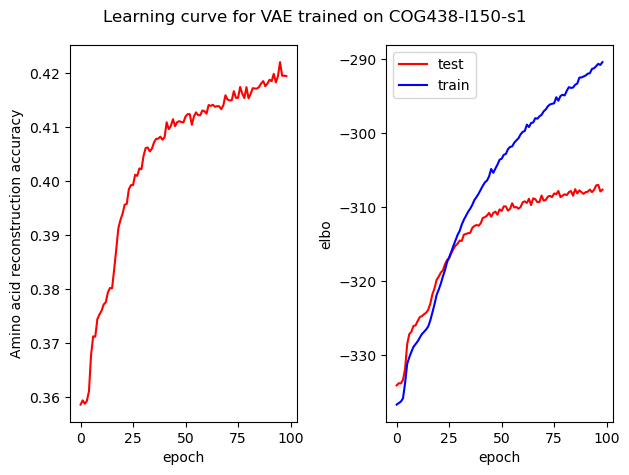

In [32]:
# plot learning curve
fig, axs = plt.subplots(1, 2)

axs[0].plot(test_recon_accs[1:], color = 'r')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel(f"Amino acid reconstruction accuracy")

axs[1].plot(test_elbos[1:], label = "test", color = 'r')
axs[1].plot(train_elbos[1:], label = "train", color = 'b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel(f"elbo")
axs[1].legend()

# add title
plt.suptitle(f"Learning curve for VAE trained on {MSA_id}")
plt.tight_layout()


There are two possible reasons why the training elbo is lower than the test elbo:
1. The training elbo is computed with weights (since during training, we want to make the model pay more attention to less typical sequences).
2. The test ELBO is computed with `compute_elbo_with_multiple_samples`, which computes an IWAE estimate of the marginal likelihood, which, recall, should be greater than the ELBO.

If the training ELBO at all exceeds the test ELBO, I think that's a good sign that there's over fitting.